# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # prevent tensorflow from using GPU

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.keras.backend.set_floatx('float64')
# TensorFlow 2 enables eager execution by default
# tf.compat.v1.enable_eager_execution()

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import mul
from sklearn.cluster import KMeans

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.1.0-dev20191015
TensorFlow Probability version: 0.9.0-dev20191016


## Generate some data

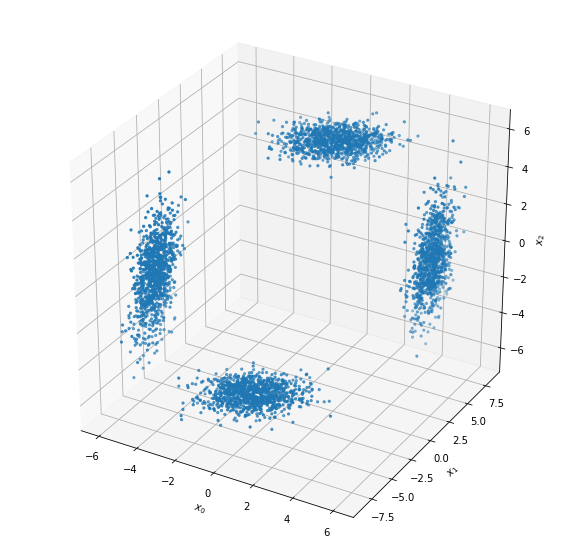

In [2]:
eps = 1e-6

n_samples_per_component = 1000
n_dims = 3
X = []
X.append(np.random.multivariate_normal([5, 5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([-5, -5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, 5, 5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, -5, -5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
n_components = len(X)
n_samples = n_samples_per_component * n_components
X = np.concatenate(X)

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Make a TensorFlow Dataset from that data

In [3]:
batch_size = 2000
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

## KL divergence between two Wishart distributions

In [4]:
@tf.function
def kl_Wishart(dist_a, dist_b):
    assert isinstance(dist_a, tfd.WishartTriL), "distribution A must be a Wishart distribution"
    assert isinstance(dist_b, tfd.WishartTriL), "distribution B must be a Wishart distribution"
    df_a = dist_a.df
    df_b = dist_b.df
    scale_a = tf.matmul(dist_a.scale_tril, tf.linalg.matrix_transpose(dist_a.scale_tril))
    scale_b = tf.matmul(dist_b.scale_tril, tf.linalg.matrix_transpose(dist_b.scale_tril))
    assert scale_a.get_shape().as_list()[-1] == scale_b.get_shape().as_list()[-1], "distribution A and B must have the same dimension"
    n_dims = scale_a.get_shape().as_list()[-1]

    def tf_multigamma(df):
        index = tf.constant(1)
        result = tf.ones_like(df)
        cond = lambda i, res: tf.less(i, n_dims+1)
        body = lambda i, res: (i+1, res * tf.exp(tf.math.lgamma(df + 0.5 * (1 - tf.cast(i, tf.float64)))))
        return tf.while_loop(cond, body, [index, result])[1]

    def Z(df, scale):
        multigamma_val = np.pi ** (0.25 * n_dims * (n_dims - 1)) * tf_multigamma(0.5 * df)  # tf.exp(scipy.special.multigammaln(0.5 * df, n_dims))
        return (2 ** (0.5 * df * n_dims)) * (tf.linalg.det(scale) ** (0.5 * df)) * multigamma_val

    return (0.5 * (df_a - df_b) * dist_a.mean_log_det() - (0.5 * df_a * n_dims) \
           + (0.5 * df_a * tf.linalg.trace(tf.matmul(tf.linalg.inv(scale_b), scale_a))) + tf.math.log(Z(df_b, scale_b) / Z(df_a, scale_a)))

## Constraint function to ensure a lower triangular matrix is positive definite

In [5]:
@tf.function
def enforce_cholesky_positive_definite(mat_tril):
    assert isinstance(mat_tril, (tf.Variable, tf.Tensor)), "input to the constraint function must be a Variable or Tensor"
    ones = tf.ones_like(mat_tril)
    mask_tril = tf.linalg.band_part(ones, -1, 0)
    mask_diag = tf.linalg.band_part(ones, 0, 0)
    mask_tril_strict = mask_tril - mask_diag
    mat_tril_strict = mask_tril_strict * mat_tril
    mat_diag_vals = tf.linalg.diag_part(mat_tril)
    mat_diag_positive = tf.linalg.diag(tf.clip_by_value(mat_diag_vals, eps, np.infty))
    return mat_tril_strict + mat_diag_positive

## Build a Gaussian Mixture Model via model subclassing
$$
\begin{aligned}
\mathbf{x}_n &\sim \sum\limits_k \pi_k \mathcal{N}\left(\pmb{\mu_x}_k, \pmb{\Sigma_x}_k\right)\\
\pi_k &\sim \mathcal{D}\left(K, \mathbf{c}\right)\\
\forall k \quad&\left\{
    \begin{aligned}
    \pmb{\Sigma_x}_k^{-1}|\mathbf{W}_k, \nu_k &\sim \mathcal{W}\left(\mathbf{W}_k, \nu_k\right)\\
    \pmb{\mu_x}_k|{\pmb{\mu_0}}_k, \lambda_k, \pmb{\Sigma_x}_k^{-1} &\sim \mathcal{N}\left({\pmb{\mu_0}}_k, {\left(\lambda_k\pmb{\Sigma_x}_k^{-1}\right)}^{-1}\right)
    \end{aligned}
\right.
\end{aligned}
$$

In [6]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model
    
    Parameters
    ----------
    n_components : int > 0
        Number of mixture components.
    n_dims : int > 0
        Number of dimensions.
    mu_init_x: Initialized mus of input space X.
    """
    def __init__(self, n_components, n_dims, mu_init):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.n_components = n_components
        self.n_dims = n_dims
        
        # Variational posterior distribution variables for covariance matrices (lower triangular)
        self.nu = tf.Variable((n_dims + 2) * tf.ones(n_components, dtype=tf.float64), name='nu', dtype=tf.float64, 
                              constraint=lambda x: tf.clip_by_value(x, n_dims+eps, np.infty))  # >= n_dims
        self.W_tril = tf.Variable(tf.linalg.diag(np.sqrt(1 / (n_dims + 2)) * tf.ones((n_components, n_dims), dtype=tf.float64)),
                                  name='W_tril', dtype=tf.float64,
                                  constraint=enforce_cholesky_positive_definite)  # lower triangular matrix with diagonal elements >= 0
        
        # Variational posterior distribution variables for multivariate means
        self.mu0 = tf.Variable(mu_init, name='mu0', dtype=tf.float64)
        self.lmbd = tf.Variable(tf.ones(n_components, dtype=tf.float64), name='lambda', dtype=tf.float64,
                                constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Variational posterior distribution variables for component weights
        self.counts = tf.Variable(2 * tf.ones(n_components, dtype=tf.float64), name='counts', dtype=tf.float64,
                                  constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Prior distributions for the inverse covariance matrices
        self.invcov_prior = tfd.WishartTriL(df=(n_dims + 2) * tf.ones(n_components, dtype=tf.float64),
                                            scale_tril=tf.linalg.diag(np.sqrt(1 / (n_dims + 2)) * tf.ones((n_components, n_dims), dtype=tf.float64)),
                                            validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the multivariate means
        self.mu_prior = tfd.MultivariateNormalTriL(loc=tf.zeros((n_components, n_dims), dtype=tf.float64),
                                                   scale_tril=tf.linalg.cholesky(tf.linalg.inv(
                                                       self.invcov_prior.sample(1)[0])),
                                                   validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(concentration=2 * tf.ones(n_components, dtype=tf.float64),
                                         validate_args=True, allow_nan_stats=False)
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """

        # The variational distributions
        invcov = tfd.WishartTriL(df=self.nu,
                                 scale_tril=self.W_tril,
                                 validate_args=True, allow_nan_stats=False)
        mu_cov = tf.linalg.inv(
            tf.stack(list(map(mul, tf.unstack(self.lmbd), [tf.eye(self.n_dims, dtype=tf.float64)] * self.n_components))) * invcov.sample(1)[0])

        mu = tfd.MultivariateNormalTriL(loc=self.mu0,
                                        scale_tril=tf.linalg.cholesky(mu_cov),
                                        validate_args=True, allow_nan_stats=False)
        theta = tfd.Dirichlet(concentration=self.counts,
                              validate_args=True, allow_nan_stats=False)
        
        # Sample from the variational distributions
        if sampling:
            batch_size = x.shape[0] # number of samples in the batch
            mu_sample = mu.sample(batch_size)
            invcov_sample = invcov.sample(batch_size)
            invcov_sample += (eps * tf.linalg.diag(tf.ones((batch_size, self.n_components, self.n_dims), dtype=tf.float64)))
            cov_sample = tf.linalg.inv(invcov_sample)
            # cov_sample = tf.linalg.pinv(invcov_sample)
            theta_sample = theta.sample(batch_size)
        else:
            mu_sample = tf.expand_dims(mu.mean(), 0)
            cov_sample = tf.expand_dims(tf.linalg.inv(invcov.mean()), 0)
            # cov_sample = tf.expand_dims(tf.linalg.pinv(invcov.mean()), 0)
            theta_sample = tf.reshape(theta.mean(), (1, self.n_components))

        # The Gaussian mixture model distribution
        gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                              components=[tfd.MultivariateNormalTriL(loc=mu_sample[:, i],
                                                                     scale_tril=tf.linalg.cholesky(cov_sample[:, i]))
                                          for i in range(self.n_components)])
                
        # Compute the mean log likelihood
        log_likelihoods = gmm.log_prob(x)
        
        # Compute the KL divergence sum
        div_invcov = kl_Wishart(invcov, self.invcov_prior)
        div_mu = tfd.kl_divergence(mu, self.mu_prior)
        div_theta = tfd.kl_divergence(theta, self.theta_prior)
        kl_sum = div_invcov + div_mu + div_theta
        
        # Return both losses
        return log_likelihoods, kl_sum

# KMeans clustering for mu initialization
X_clu = KMeans(n_clusters=n_components).fit(X)

# model instantiation
model = GaussianMixtureModel(n_components, n_dims, X_clu.cluster_centers_)

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.MatvecLinearOperator(...))`.


## Model fitting

In [7]:
lr = 2e-3
optimizer = tf.keras.optimizers.Adam(lr=lr)

loss_nll = tf.keras.metrics.Mean(name='negative_log_likelihoods')
loss_kl = tf.keras.metrics.Mean(name='KL_divergence')
loss_train = tf.keras.metrics.Mean(name='loss_train')

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        neg_elbo = tf.reduce_mean(kl_sum/n_samples) - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(neg_elbo, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    # record metrics
    loss_nll(-tf.reduce_mean(log_likelihoods))
    loss_kl(tf.reduce_mean(kl_sum/n_samples))
    loss_train(neg_elbo)
    
# Fit the model
n_epochs = 5000
n_epochs_per_print = 100
for epoch in range(n_epochs):
    for data in dataset:
        train_step(data)
    if (epoch + 1) % n_epochs_per_print == 0:
        print('Epoch {}: nll = {:.4f}, kl = {:.4f}, -elbo = {:.4f}'.format(epoch+1,
                                                                           loss_nll.result(),
                                                                           loss_kl.result(),
                                                                           loss_train.result()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 100: nll = 7.8803, kl = 0.0075, -elbo = 7.8878
Epoch 200: nll = 7.5465, kl = 0.0080, -elbo = 7.5545
Epoch 300: nll = 7.3043, kl = 0.0085, -elbo = 7.3128
Epoch 400: nll = 7.1223, kl = 0.0089, -elbo = 7.1312
Epoch 500: nll = 6.9734, kl = 0.0092, -elbo = 6.9826
Epoch 600: nll = 6.8556, kl = 0.0095, -elbo = 6.8651
Epoch 700: nll = 6.7562, kl = 0.0097, -elbo = 6.7658
Epoch 800: nll = 6.6735, kl = 0.0098, -elbo = 6.6834
Epoch 900: nll = 6.6012, kl = 0.0099, -elbo = 6.6112
Epoch 1000: nll = 6.5344, kl = 0.0100, -elbo = 6.5445
Epoch 1100: nll = 6.4729, kl = 0.0101, -elbo = 6.4830
Epoch 1200: nll = 6.4183, kl = 0.0102, -elbo = 6.4285
Epoch 1300: nll = 6.3691, kl = 0.0103, -elbo = 6.3794
Epoch 1400: nll = 6.3229, kl = 0.0103, -elbo = 6.3333
Epoch 1500: nll = 6.2806, kl = 0.0104, -elbo = 6.2910
Epoch 1600: nll = 6.2410, kl = 0.0104, -elbo = 6.2514
Epoch 1700: nll = 6.2034, kl = 0.0105, -elbo = 6.2139
Epoc

## Plot log-likelihood (sliced on the $x_2$ axis)

Instructions for updating:
Do not call `graph_parents`.


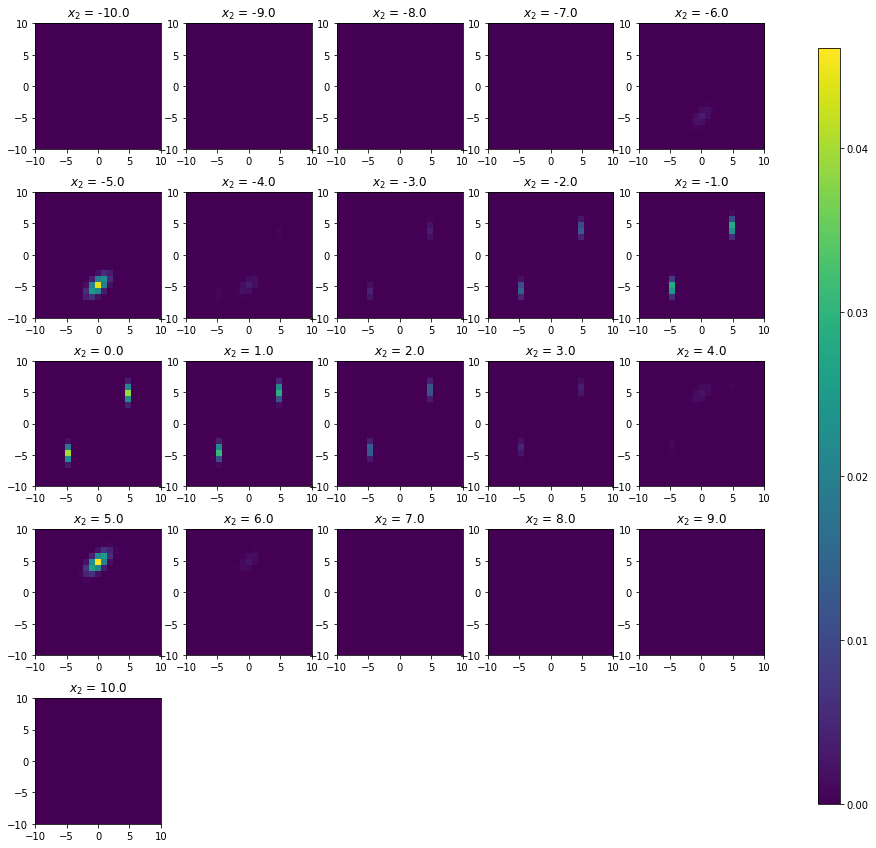

In [8]:
# Compute log likelihood at each point on a grid
n_grids = 21 # number of grid points
x0_, x1_, x2_ = np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids)
x0_grid, x1_grid, x2_grid = np.meshgrid(x0_, x1_, x2_)
grids = np.column_stack([x0_grid.flatten(), x1_grid.flatten(), x2_grid.flatten()])
ll, _ = model(grids.astype('float64'), sampling=False)
ll = np.reshape(ll, (n_grids, n_grids, n_grids))
        
# Show the fit loglikelihood (slices of x2-axis)
n_subplot_rows = 5
fig, ax = plt.subplots(n_subplot_rows, n_grids // n_subplot_rows + 1, figsize=(15, 15))
for i in range(n_subplot_rows):
    for j in range(n_grids // n_subplot_rows + 1):
        idx = i * (n_grids // n_subplot_rows + 1) + j
        if idx < n_grids:
            im = ax[i, j].imshow(np.exp(ll)[:, :, idx], extent=(-10, 10, -10, 10), origin='lower',
                                 vmin=0, vmax=np.exp(ll).max())
            ax[i, j].title.set_text('$x_2$ = {}'.format(x2_[idx]))
        else:
            ax[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Output trainable variables

In [9]:
{v.name: v.numpy() for v in model.trainable_variables}

{'nu:0': array([16.9098636 , 16.97382941, 16.5882752 , 16.16255419]),
 'W_tril:0': array([[[ 0.3019944 ,  0.        ,  0.        ],
         [-0.18701942,  0.23701278,  0.        ],
         [ 0.00503592, -0.01934881,  0.58333451]],
 
        [[ 0.75912929,  0.        ,  0.        ],
         [-0.01172685,  0.28324354,  0.        ],
         [ 0.00575226, -0.09114657,  0.16842531]],
 
        [[ 0.76848838,  0.        ,  0.        ],
         [ 0.01079086,  0.26559355,  0.        ],
         [ 0.00093294, -0.07886372,  0.17865594]],
 
        [[ 0.30985103,  0.        ,  0.        ],
         [-0.18378235,  0.24858054,  0.        ],
         [ 0.00172124, -0.01001849,  0.55349496]]]),
 'mu0:0': array([[-3.35746485e-02,  4.99044567e+00,  4.99340208e+00],
        [-5.00073905e+00, -5.06759153e+00,  2.37235921e-02],
        [ 4.99980041e+00,  4.97035684e+00,  3.62121083e-03],
        [-3.08552627e-02, -5.03679941e+00, -4.99858903e+00]]),
 'lambda:0': array([10.54774955, 10.51175547, 10.55

## Pairwise plot

Mean of covariance matrices (for each component):
[array([[1.36954597, 0.84950506, 0.00872861],
       [0.84950506, 1.37892708, 0.01844175],
       [0.00872861, 0.01844175, 0.22561853]]), array([[ 0.13425784,  0.01411033, -0.0054695 ],
       [ 0.01411033,  1.23810089,  0.87143618],
       [-0.0054695 ,  0.87143618,  2.72748784]]), array([[ 0.13413721, -0.02086368, -0.01434289],
       [-0.02086368,  1.34829826,  0.73260904],
       [-0.01434289,  0.73260904,  2.47551843]]), array([[1.3413858 , 0.79797646, 0.00715863],
       [0.79797646, 1.34163862, 0.01201404],
       [0.00715863, 0.01201404, 0.26690259]])]
Mean of mus (for each component):
[array([-0.03464484,  4.98740353,  4.99292719]), array([-5.00052558, -5.07048498,  0.01601925]), array([4.99920454e+00, 4.97265977e+00, 2.52987954e-03]), array([-0.02728837, -5.04498437, -4.99719985])]


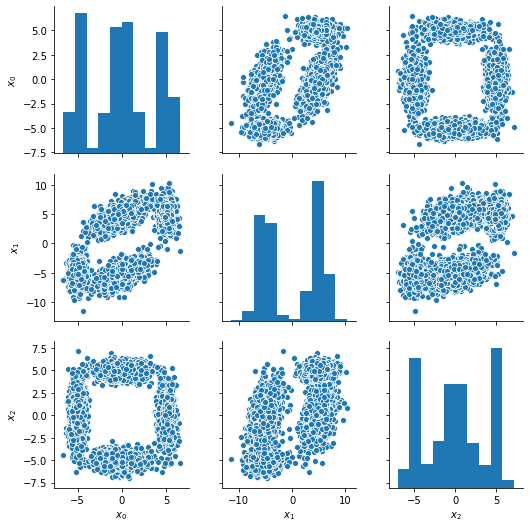

In [10]:
test_size = 10000

# sample covariance matrix
invcov = tfd.WishartTriL(df=model.nu,
                         scale_tril=model.W_tril,
                         validate_args=True, allow_nan_stats=False)
invcov_sample = invcov.sample(test_size)
invcov_sample += (eps * tf.linalg.diag(tf.ones((test_size, n_components, n_dims), dtype=tf.float64)))
cov_sample = tf.linalg.inv(invcov_sample)
print('Mean of covariance matrices (for each component):\n{}'.format(
    [tf.reduce_mean(cov_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample mean
mu_cov = tf.linalg.inv(
    tf.stack(list(map(mul, tf.unstack(model.lmbd), [tf.eye(n_dims, dtype=tf.float64)] * n_components))) * invcov.sample(1)[0])
mu = tfd.MultivariateNormalTriL(loc=model.mu0,
                                scale_tril=tf.linalg.cholesky(mu_cov),
                                validate_args=True, allow_nan_stats=False)
mu_sample = mu.sample(test_size)
print('Mean of mus (for each component):\n{}'.format(
    [tf.reduce_mean(mu_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample theta
theta = tfd.Dirichlet(concentration=model.counts,
                      validate_args=True, allow_nan_stats=False)
theta_sample = theta.sample(test_size)

# build Gaussian mixture model and sample
gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                  components=[tfd.MultivariateNormalTriL(loc=mu_sample[:, i],
                                                         scale_tril=tf.linalg.cholesky(cov_sample[:, i]))
                              for i in range(model.n_components)])
gmm_sample = gmm.sample(1)[0]

# build dataset
dataset = pd.DataFrame({'$x_0$': gmm_sample[:, 0],
                        '$x_1$': gmm_sample[:, 1],
                        '$x_2$': gmm_sample[:, 2]})
fig_sns = sns.pairplot(dataset)